# Imports

In [1]:
import numpy as np
#import uuid
#import pandas as pd
import os
import bz2
import random
#import scipy.stats as stats
import json
#import seaborn as sns
import qwikidata
#import matplotlib.pyplot as plt
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.linked_data_interface import get_entity_dict_from_api
from collections import Counter
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme
import sqlite3
from itertools import islice
import time
from pprint import pprint
import traceback
import psycopg2

# Parse Dumps

In [2]:
wjd = WikidataJsonDump('data/latest-all.json.bz2')
# On Feb 13 2020 it had 77,175,441 entities
# On Apr 16 2020 it had 82,402,738 entities

In [3]:
db_sys = 'SQLITE'
if db_sys == 'SQLITE':
    db = sqlite3.connect('data/wikidata_apr.db')
elif db_sys == 'POSTGRESQL':
    db = psycopg2.connect(database="wikidata", user="postgres", password="xin77812", host="127.0.0.1", port="5432")
cursor = db.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS claims(
        entity_id TEXT,
        claim_id TEXT,
        claim_rank TEXT,
        property_id TEXT,
        datatype TEXT,
        datavalue TEXT,
        PRIMARY KEY (
            claim_id
        )
)''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS claims_refs(
        claim_id TEXT,
        reference_id TEXT,
        PRIMARY KEY (
            claim_id,
            reference_id
        )
)''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS refs(
        reference_id TEXT,
        reference_property_id TEXT,
        reference_index TEXT,
        reference_datatype TEXT,
        reference_value TEXT,
        PRIMARY KEY (
            reference_id,
            reference_property_id,
            reference_index
        )
)''')
db.commit()

In [4]:
def consume(iterator, n=None):
    "Advance the iterator n-steps ahead. If n is None, consume entirely."
    # Use functions that consume iterators at C speed.
    if n is None:
        # feed the entire iterator into a zero-length deque
        collections.deque(iterator, maxlen=0)
    else:
        # advance to the empty slice starting at position n
        next(islice(iterator, n, n), None)

In [5]:
def parse_picks(picks, last_pick, f, savepoints, extraction_fun, get_sizes=False, verbose=True):
    sizes = []
    '''
    - picks is the list of picked positions in the dump to extract
    - last_pick: is the last picked position in the dump (from picks) to have been succesfully extracted to the DB.
    when it is -1 it means no picked position from the dump was extracted. This is returned at the end to mark where
    the extraction stopped.
    - f is the file itself
    - savepoints is the actual byte position in the file where the entity is the respective picked position was found. For
    example, savepoints[42] returns the byte position in the file where the entity in position picks[24] of the dump begins.
    - index_start is the index on the picks list where to start reading next. If last_pick is -1, then index_start
    should be 0, as the first index should be the one extracted. Otherwise, it should begin on the following pick to
    last_pick, which means picks.index(last_pick)+1.
    ''' 
    if last_pick == -1:
        index_start = 0
        f.seek(0) #If last_pick is -1, no extraction took place and we seek the beginning of the file
        consume(f,1) #skipping first {
    else:
        '''
        If the extraction is continuing from a past run, then last_pick is the picked position last extracted successfully.
        Thus we need to jump to the position the file reader would be if it didn't finish halfway through.
        This would be on the position right after consuming the entity represented by last_pick.
        To find that, we do:
        '''
        index_start = picks.index(last_pick)+1 # As described at the start, we take the index of the pick following last_pick
        # to start the loop
        f.seek(savepoints[index_start-1]) # We get the position in the file where the last_pick entity starts 
        consume(f,1)    # and then we skip that entity
    try:
        for i, pick in enumerate(picks[index_start:]):
            '''
            If the extraction is starting from zero, last_pick is -1 and we consume pick - (-1) -1, which is pick, so
            we jump 'pick' number of lines and land on the 'pick'est line, as pick is 0-indexed 
            Exemple: pick is 0, so we jump 0 lines and get the first element of the dump.
            Exemple: pick is 42, so we jump 42 lines and get the 43rd element of the dump; which, picks being 0-indexed,
            is what pick=42 means!
            
            If the extraction is continuing a loop that started from scratch, then pick is the picked position following
            last_pick in the picks list. In this case, we jump the lines between the end of last_pick and the beginning of
            pick. This would be pick-last_pick-1, and not just pick-last_pick, as we are skipping the number of entities 
            BETWEEN them.
            Exemple: last_pick is 42, and pick is 46. We already read entity 42, so the reader is at the very start of 
            43. We jump 43, 44, and 45, landing on the beginning of 46, so 3 entities. 46-42-1 = 3.
            
            If, however, the extraction is following another extraction after successfully extracting a last_pick entity,
            then as per the code above, pick will start by being the picked position following last_pick in the picks list,
            so we go back to the case above.
            '''
            consume(f, pick - last_pick - 1)
            savepoints[index_start+i] = f.tell() # We register the starting position of this entity in the savepoints
            linebytes = f.readline() # We consume the entity. 
            # THIS PUTS THE POINTER AT THE END OF THIS ENTITY/START OF THE NEXT
            if get_sizes:
                sizes.append(len(linebytes))
            line_str = linebytes.decode('utf-8') # We decode the bytes
            line_str = line_str.rstrip(',\n')
            entity = json.loads(line_str)
            #print('{} : {} : {} : {}'.format(index_start+i,pick,entity['id'], savepoints[index_start+i]))
            if verbose:
                print(str(pick/77175441*100)+'%'+20*' ',end='\r')
            extraction_fun(entity)        
            last_pick = pick
    except Exception as err:
        print(err, e['id'])
        traceback.print_exc()
        raise err
    finally:
        db.commit()
        if get_sizes:
            return last_pick, sizes
        return last_pick
        
def reset_picks(filename, picks):
    f = bz2.open(filename, mode="rb")
    last_pick = -1
    savepoints = [None] * len(picks)
    return last_pick, f, savepoints

In [6]:
# GENERATE THE PICKED POSITIONS REPRESENTING 20% OF THE DUMPS
estimated_size = 77175441
np.random.seed(estimated_size) #we use the estimated size as seed too because why not
picks = np.random.choice(estimated_size,size=int((.2)*estimated_size),replace=False) # We randomly pick 20% of total
picks = sorted(picks)

In [7]:
# SANITY CHECK TO SEE IF THE EXTRACTION IS GETTING THE PICKS, CHECK THE FIRST Nth PICKS
first_n = []
n = 100
for i,e in enumerate(wjd):
    if i in picks[:n]:
        first_n.append(e['id'])
    if len(first_n) == n:
        break

first_n_extraction = []
def put_entity_in_list(e):
    global first_n_extraction
    first_n_extraction.append(e['id'])
    
last_pick, f, savepoints = reset_picks('data/latest-all.json.bz2', picks)
last_pick = parse_picks(picks[:n], last_pick, f, savepoints, put_entity_in_list, verbose=False)

try:
    assert(first_n == first_n_extraction)
except:
    print("Something is wrong, Gaby!")
else:
    print("All is good, Gaby!")

All is good, Gaby!


In [8]:
def extract_claim(entity_id,claim):
    if claim['mainsnak']['snaktype'] == 'value':
        value = str(claim['mainsnak']['datavalue'])
    else:
        value = claim['mainsnak']['snaktype']
    try:
        cursor.execute('''
        INSERT INTO claims(entity_id, claim_id, claim_rank, property_id, datatype, datavalue)
        VALUES($var,$var,$var,$var,$var,$var)'''.replace('$var','?'), (
            entity_id,claim['id'],claim['rank'],
            claim['mainsnak']['property'],claim['mainsnak']['datatype'],value
        ))
        #db.commit()
    except UnicodeEncodeError:
        print(entity_id,claim['id'],claim['rank'],
            claim['mainsnak']['property'],claim['mainsnak']['datatype'],value)
        raise
    except (sqlite3.IntegrityError,psycopg2.IntegrityError) as err:
        #db.rollback()
        cursor.execute(
            '''SELECT *
            FROM claims 
            WHERE claim_id=$var
            '''.replace('$var','?'), (claim['id'],)
        )
        conflicted_value = cursor.fetchone()
        if conflicted_value == (entity_id,claim['id'],claim['rank'],
                claim['mainsnak']['property'],claim['mainsnak']['datatype'],value):
            pass
        else:
            print(err, claim['id'])
            traceback.print_exc()
            raise err

def extract_reference(ref):
    for snaks in ref['snaks'].values():
        for i, snak in enumerate(snaks):
            if snak['snaktype'] == 'value':
                value = str(snak['datavalue'])
            else:
                value = snak['snaktype']
            try:
                cursor.execute('''
                INSERT INTO refs(reference_id, reference_property_id, reference_index,
                reference_datatype, reference_value)
                VALUES($var,$var,$var,$var,$var)'''.replace('$var','?'), (
                    ref['hash'],snak['property'],str(i),snak['datatype'],value
                ))
                #db.commit()
            except (sqlite3.IntegrityError,psycopg2.IntegrityError) as err:
                #db.rollback()
                cursor.execute(# WE DONT USE THE INDEX HERE, THEY TEND TO COME SUFFLED FROM API AND SORTING TAKES TOO LONG
                    '''SELECT reference_id, reference_property_id, reference_datatype, reference_value
                    FROM refs 
                    WHERE reference_id = $var
                    AND reference_property_id = $var
                    '''.replace('$var','?'), (ref['hash'],snak['property'])
                )
                conflicted_values = cursor.fetchall()
                if  (ref['hash'],snak['property'],snak['datatype'],value) in conflicted_values:
                    pass
                else:
                    print(err, ref['hash'],snak['property'],i)
                    print('in the db:', conflicted_value)
                    print('trying to insert:',(ref['hash'],snak['property'],str(i),snak['datatype'],value))
                    traceback.print_exc()
                    raise err
            
def extract_claim_reference(claim,ref):
    claim['id'],ref['hash']
    try:
        cursor.execute('''
        INSERT INTO claims_refs(claim_id, reference_id)
        VALUES($var,$var)'''.replace('$var','?'), (
            claim['id'],ref['hash']
        ))
        #db.commit()
    except (sqlite3.IntegrityError,psycopg2.IntegrityError) as err:
        #db.rollback()
        pass
    
def extract_entity(e):
    for outgoing_property_id in e['claims'].values():
        for claim in outgoing_property_id:
            extract_claim(e['id'],claim)
            if 'references' in claim:
                for ref in claim['references']: 
                    extract_claim_reference(claim, ref)
                    extract_reference(ref)

In [ ]:
# ACTUALLY RUN THE EXTRACTION
last_pick, f, savepoints = reset_picks('data/latest-all.json.bz2', picks)
last_pick = parse_picks(picks, last_pick, f, savepoints, extract_entity)
last_pick

## This piece of code below is to test if this actually reduces the time of continuous reads.

To test it again, please *comment out* the line in *extract_picks* where the extraction takes place.

Also, put *get_sizes=True* so that it returns the sizes, as we use this to normalize the graphs

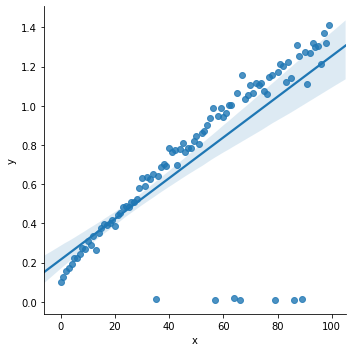

In [229]:
# This resets the file ONCE and reads by batches of 10 by using savepoints

last_pick, f, savepoints = reset_picks('data/latest-all.json.bz2', picks)
x = []
y = []
for i in range(100):
    
    start = time.time()
    last_pick, sizes = extract_picks(picks[:10*(i+1)], last_pick, f, savepoints, get_sizes=True)
    end = time.time()
    y.append(end - start)
    x.append(np.sum(sizes))
    #print(time.time() - start, np.sum(sizes))
f.close()
    
z = [y[i]/np.log(x[i]) for i in range(len(x))]
data = pd.DataFrame({'x':range(len(x)),'y':z})
sns.lmplot(x='x',y='y',data=data)

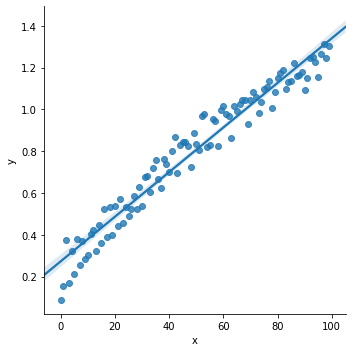

In [230]:
# This resets the file everytime it starts to read

x2 = []
y2 = []
for i in range(100):
    last_pick, f, savepoints = reset_picks('data/latest-all.json.bz2', picks)
    start = time.time()
    last_pick, sizes = extract_picks(picks[:10*(i+1)], last_pick, f, savepoints, get_sizes=True)
    end = time.time()
    y2.append(end - start)
    x2.append(np.sum(sizes))
    f.close()
    #print(time.time() - start, np.sum(sizes))

z2 = [y2[i]/np.log(x2[i]) for i in range(len(x2))]
data2 = pd.DataFrame({'x':range(len(x2)),'y':z2})
sns.lmplot(x='x',y='y',data=data2)

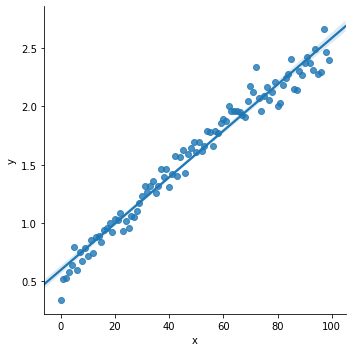

In [256]:
# This uses the dump file and the qwikidata module
x3 = []
y3 = []
for i in range(100):
    wjd = WikidataJsonDump('data/latest-all.json.bz2')
    sizes = []
    start = time.time()
    for j, entity in enumerate(wjd):
        if j in picks[:10*(i+1)]:
            sizes.append(len(str(entity)))
            if j == picks[:10*(i+1)][-1]:
                break
    end = time.time()
    y3.append(end - start)
    x3.append(np.sum(sizes))

z3 = [y3[i]/np.log(x3[i]) for i in range(len(x3))]
data3 = pd.DataFrame({'x':range(len(x3)),'y':z3})
sns.lmplot(x='x',y='y',data=data3)

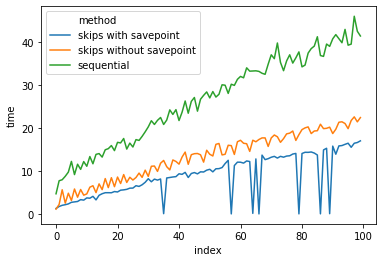

In [257]:
times_df = pd.DataFrame({
    'index':list(range(len(y)))+list(range(len(y2)))+list(range(len(y3))),
    'time':y+y2+y3,
    'method':len(y)*['skips with savepoint']+len(y2)*['skips without savepoint']+len(y3)*['sequential']
})
sns.lineplot(x='index',y='time',hue='method',data=times_df)